# Predicting Loan Payback

![Kaggle Challenge](./assets/challenge.png)

This project focuses on predicting whether a borrower will repay their loan based on various features such as credit score, income, loan amount, and more. We will use machine learning techniques to build a predictive model. It is a **Kaggle Competition** part of the **Kaggle Playground Series (S5 E11)**


## 1. Import Libraries

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder

import pandas as pd
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

from lightgbm import LGBMClassifier
import lightgbm as lgb
from scipy.stats import uniform, randint
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## 2. Load Dataset

In [60]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

In [61]:
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [62]:
print(f"Train shape {train.shape}")
print(f"Test shape {test.shape}")

Train shape (593994, 12)
Test shape (254569, 11)


In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64  
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object 
 6   marital_status        593994 non-null  object 
 7   education_level       593994 non-null  object 
 8   employment_status     593994 non-null  object 
 9   loan_purpose          593994 non-null  object 
 10  grade_subgrade        593994 non-null  object 
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 54.4+ MB



### About the Dataset

This dataset contains various features related to borrowers and the loans they received, culminating in a target variable indicating whether the loan was paid back.

#### 1. Borrower’s Demographics

* **gender** (`category`) – Borrower's gender (Male/Female).
* **marital\_status** (`category`) – Marital status (Single, Married, Divorced).
* **education\_level** (`category`) – Education level (High School, Bachelor, Master, PhD).

#### 2. Financial Information

* **annual\_income** (`float64`) – Borrower's yearly income.
* **employment\_status** (`category`) – Current employment type (Employed, Self-Employed, Unemployed).
* **debt\_to\_income\_ratio** (`float64`) – Ratio of borrower’s debt to their income. **Lower = better.**
* **credit\_score** (`int64`) – Credit bureau score (e.g., FICO). It shows how financially reliable you are (300–579: Poor, 580–669: Fair, 670–739: Good, 740+: Excellent)

#### 3. Loan Information

* **loan\_amount** (`float64`) – Amount of loan taken.
* **loan\_purpose** (`category`) – Loan purpose (Car, Education, Home, Medical, etc.).
* **interest\_rate** (`float64`) – Loan par annual interest rate (%).
* **grade\_subgrade** (`category`) – Risk category assigned to loan (A1, B2, C1,etc.).


#### 5. Target Variable

* **loan\_paid\_back** (`int64`) – Target variable:
    * **1** → Borrower paid loan in full.
    * **0** → Borrower defaulted (did not repay fully).

### Evaluation

The challenge is evaluated on area under the ROC curve **(AUC-ROC)** between the predicted probability and the observed target. So it's **Binary Classification** problem

![AUC-ROC Curve](./assets/AUC-ROC.png)


## 3. Exploratory Data Analysis

### Check Null and Duplicate Values

In [64]:
print("Number of null value in Train : ",train.isna().sum().sum())
print("Number of null value in Test : ",test.isna().sum().sum())

Number of null value in Train :  0
Number of null value in Test :  0


### Exploring target Variable

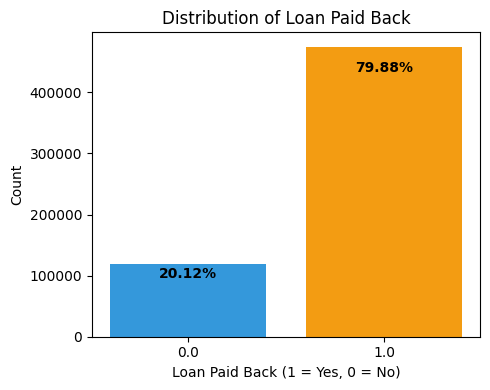

In [65]:
target_counts = train['loan_paid_back'].value_counts()
target_counts = train['loan_paid_back'].value_counts().sort_index()
target_percent = train['loan_paid_back'].value_counts(normalize=True) * 100


# 2. Plot
plt.figure(figsize=(5,4))
bars = plt.bar(target_counts.index.astype(str),
               target_counts.values,
               color=['#3498db', '#f39c12'])

# Add percentage labels on each bar
for bar in bars:
    height = bar.get_height()
    percent = (height / target_counts.sum()) * 100
    plt.text(bar.get_x() + bar.get_width()/2, height * 0.95,
             f'{percent:.2f}%', ha='center', va='top', fontsize=10, fontweight='bold')

plt.title('Distribution of Loan Paid Back')
plt.xlabel('Loan Paid Back (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The target variable shows a **moderate class imbalance**, with significantly fewer default cases. (80/20)

As a result, a naive model that always predicts repayment (1.0) would already achieve around 80% accuracy, yet its ROC-AUC would be poor since it fails to distinguish risk levels. 

For this reason, **ROC-AUC** is chosen as the **primary evaluation metric**, as it better captures the model’s ability to discriminate between repaid and defaulted loans.

Overall, approximately 80% of loans are repaid, while 20% result in default.

### Divide Numerical and Categorical Columns

In [70]:
target_col = 'loan_paid_back'

num_cols = train.select_dtypes(exclude= 'object').columns.drop('loan_paid_back')
cat_cols = train.select_dtypes(include= 'object').columns


print(f"\n Numerical features ({len(num_cols)}):")
for i, col in enumerate(num_cols, 1):
    print(f"   {i}. {col}")
print("="*50)
print(f"\n Categorical features ({len(cat_cols)}):")
for i, col in enumerate(cat_cols, 1):
    print(f"   {i}. {col}")

print(f"\n Total  features: {len(num_cols) + len(cat_cols)}")


 Numerical features (5):
   1. annual_income
   2. debt_to_income_ratio
   3. credit_score
   4. loan_amount
   5. interest_rate

 Categorical features (6):
   1. gender
   2. marital_status
   3. education_level
   4. employment_status
   5. loan_purpose
   6. grade_subgrade

 Total  features: 11


### I. Exploring Numerical Features

In [67]:
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990


In [68]:
num_cols

Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate'],
      dtype='object')

#### Correlation Matrix

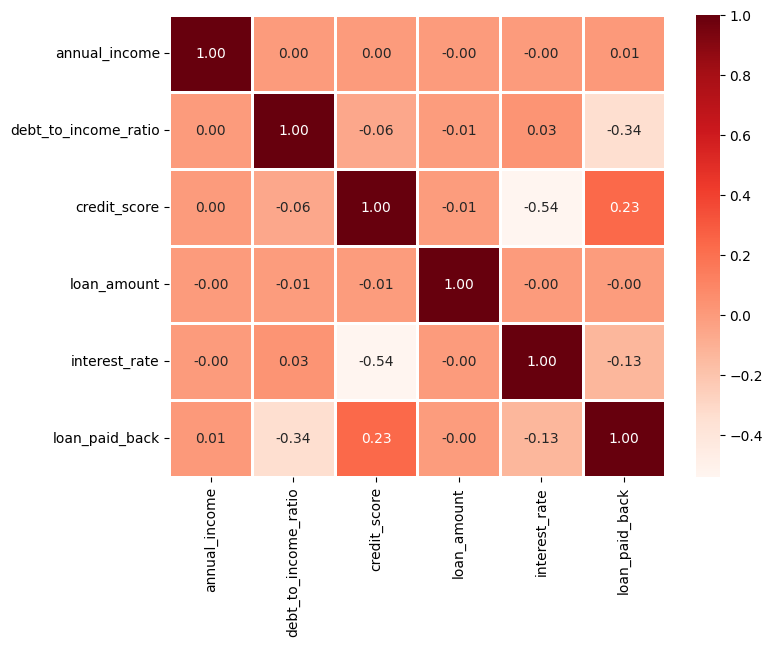

In [77]:
plt.figure(figsize=(8, 6))
cols_to_corr = num_cols.tolist() + [target_col]
correlation_matrix = train[cols_to_corr ].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            linewidths=1, cmap="Reds")
plt.show()

#### Distributions

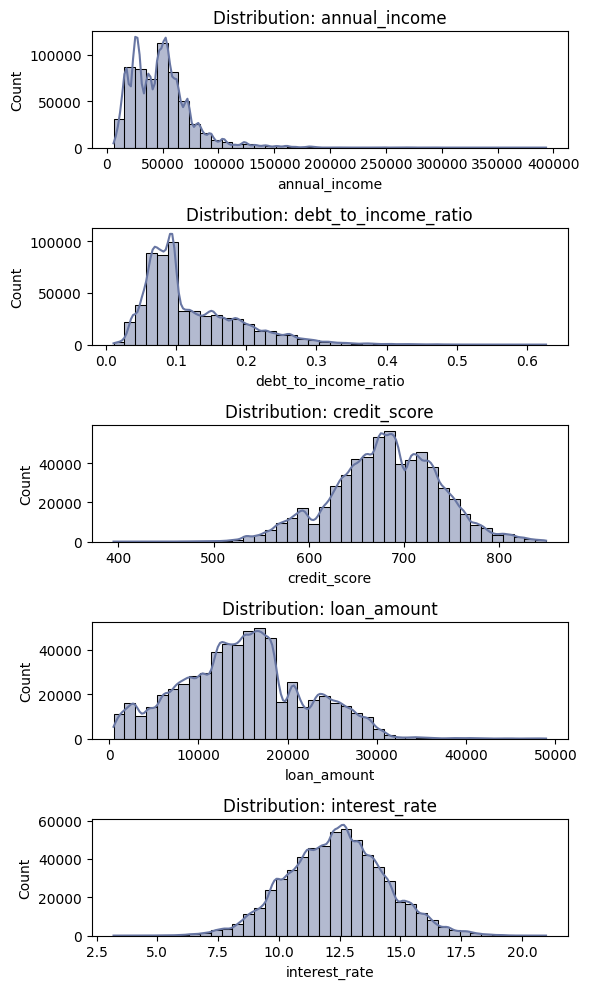

In [82]:
plt.figure(figsize=(6, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.histplot(train[col], kde=True, bins=40, color="#6876a3")
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()



annual_income Summary Statistics:


,Train,Test
Mean,48212.202976,48233.080193
Median,46557.680000,46528.980000
Std,26711.942078,26719.658580


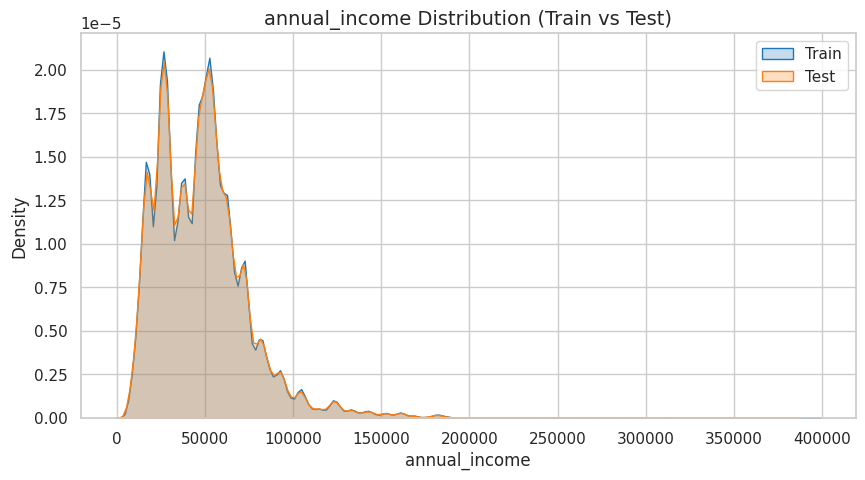


debt_to_income_ratio Summary Statistics:


,Train,Test
Mean,0.120696,0.120583
Median,0.096000,0.096000
Std,0.068573,0.068582


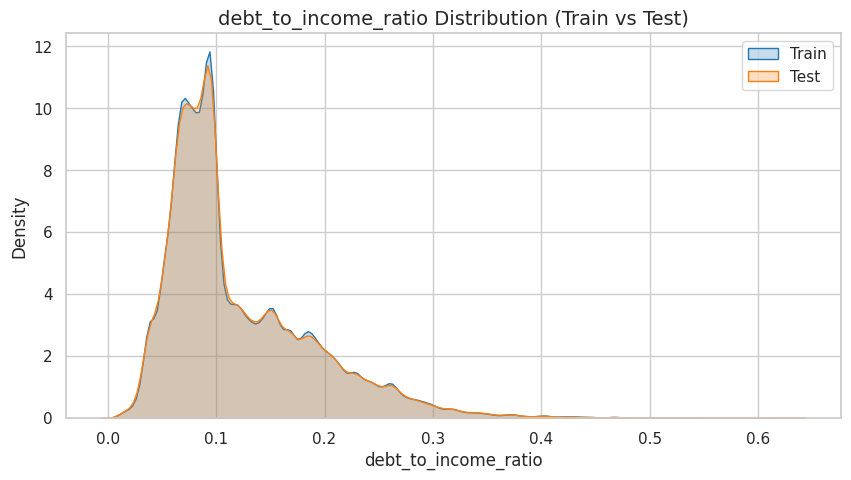


credit_score Summary Statistics:


,Train,Test
Mean,680.916009,681.037691
Median,682.000000,683.000000
Std,55.424956,55.624118


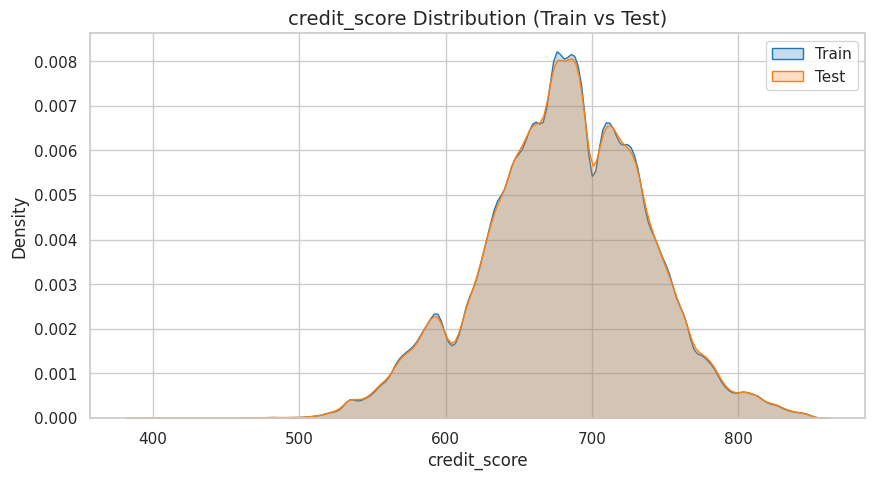


loan_amount Summary Statistics:


,Train,Test
Mean,15020.297629,15016.753484
Median,15000.220000,15000.220000
Std,6926.530568,6922.165182


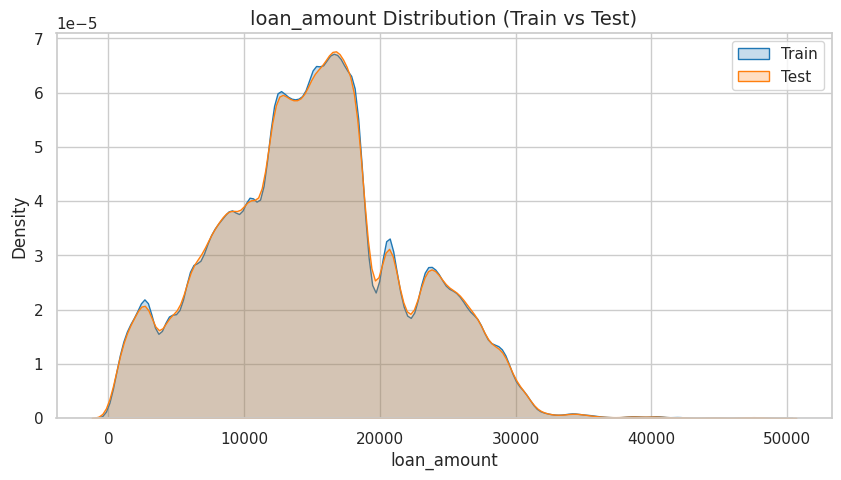


interest_rate Summary Statistics:


,Train,Test
Mean,12.356345,12.352323
Median,12.370000,12.370000
Std,2.008959,2.017602


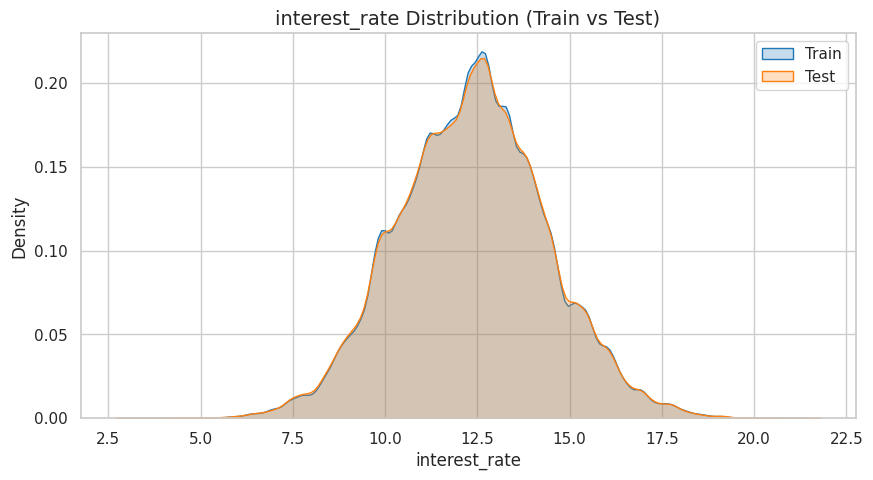

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("notebook")

palette = ['#1f77b4', '#ff7f0e']  

for col in num_cols: 
    # Summary statistics
    print(f"\n{col} Summary Statistics:")
    display(pd.DataFrame({
        'Train': [train[col].mean(), train[col].median(), train[col].std()],
        'Test': [test[col].mean(), test[col].median(), test[col].std()]
    }, index=['Mean', 'Median', 'Std']))
    
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=train, x=col, fill=True, label='Train', color=palette[0])
    sns.kdeplot(data=test, x=col, fill=True, label='Test', color=palette[1])
    plt.title(f'{col} Distribution (Train vs Test)', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


#### Outliers

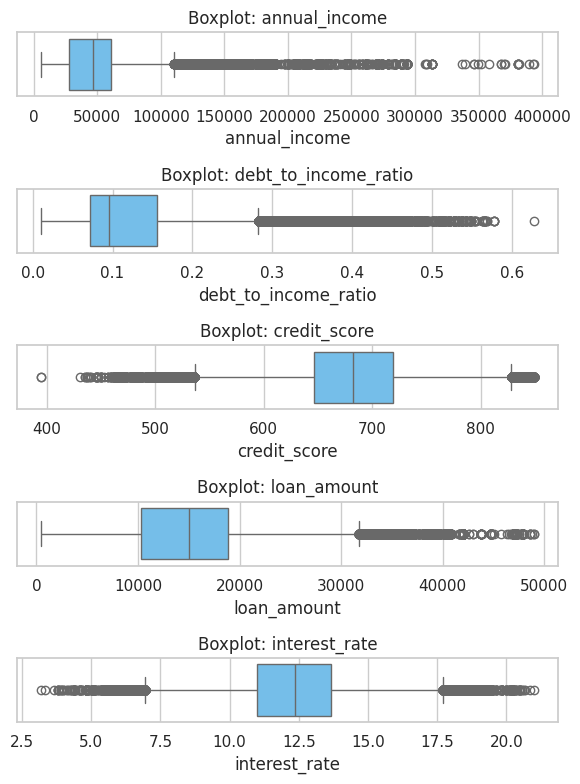

In [87]:
plt.figure(figsize=(6, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=train[col], color="#62c3fc")
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()
